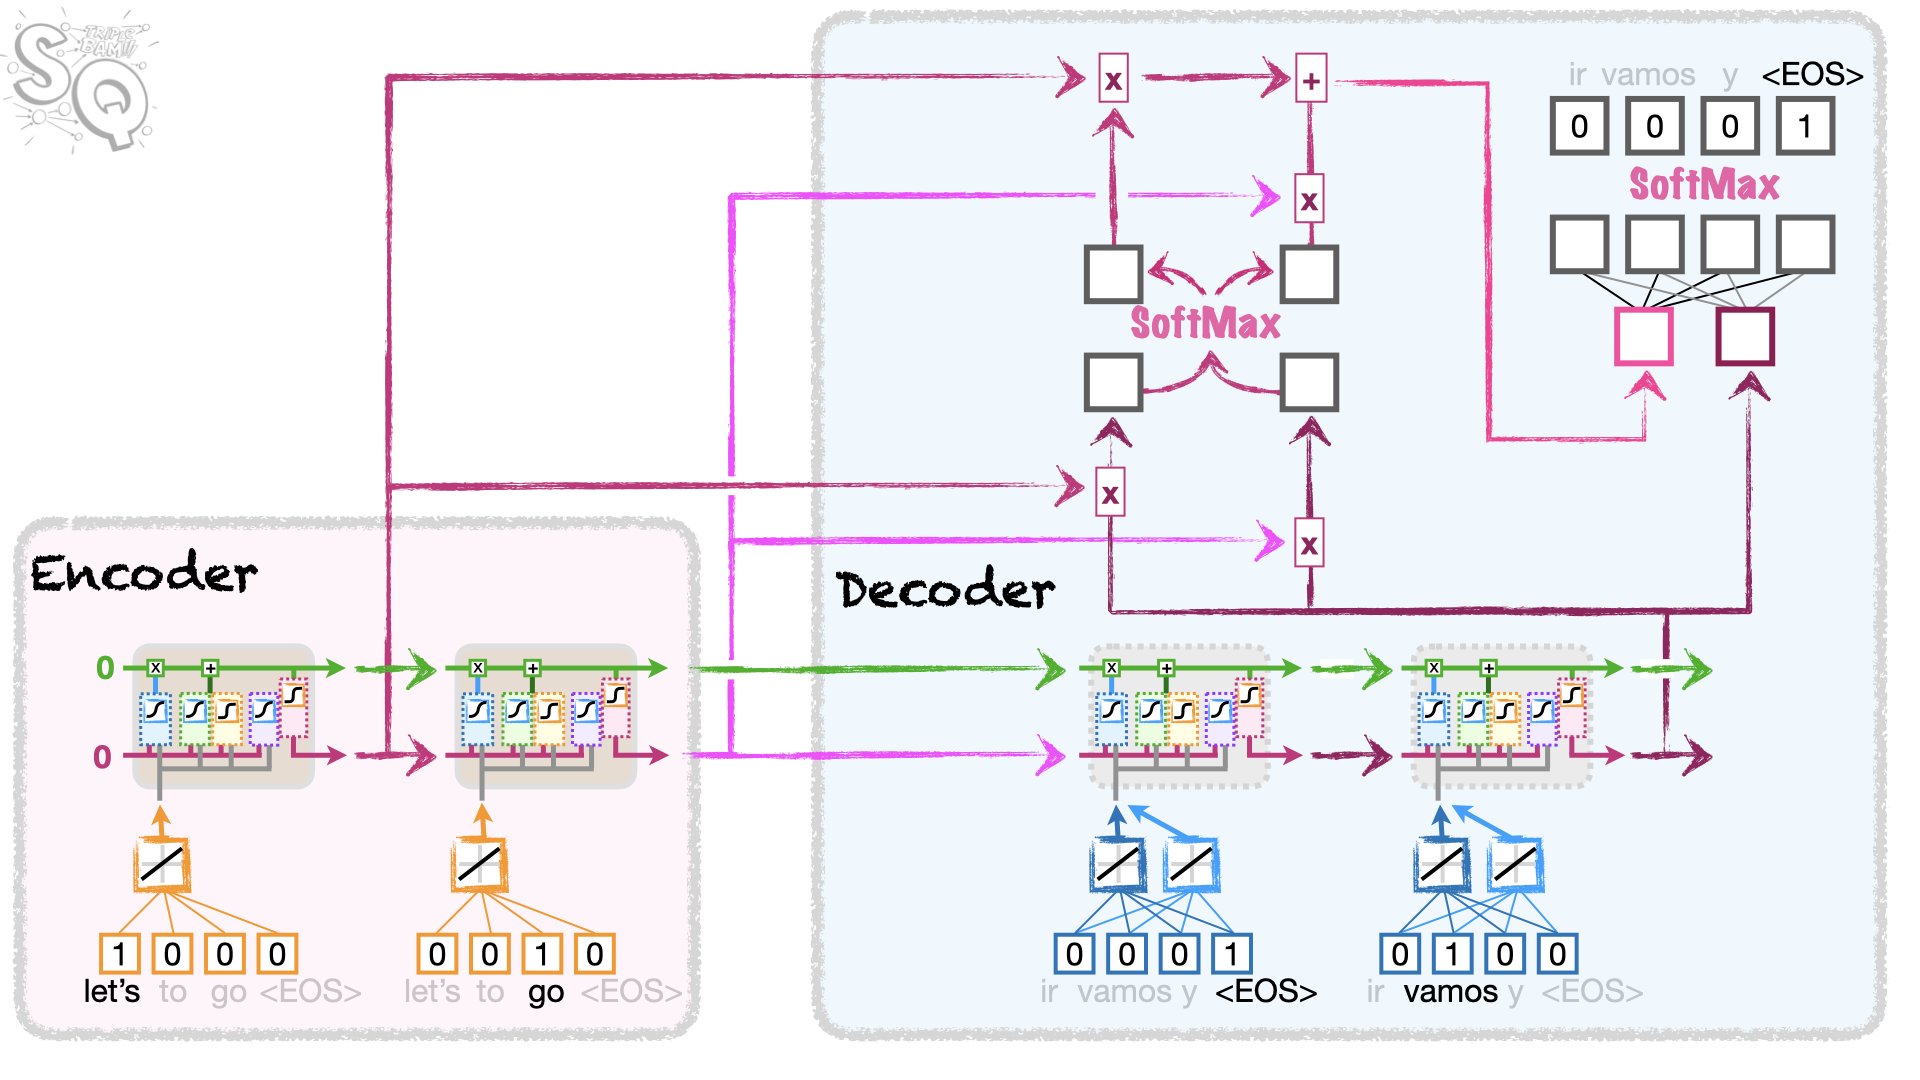

In [1]:
import torch  ## torch let's us create tensors and also provides helper functions
import torch.nn as nn  ## torch.nn gives us nn.Module(), nn.Embedding() and nn.Linear()
import torch.nn.functional as F  # This gives us the softmax() and argmax()
from torch.optim import Adam  ## We will use the Adam optimizer, which is, essentially,

## a slightly less stochastic version of stochastic gradient descent.
from torch.utils.data import (
    TensorDataset,
    DataLoader,
)  ## We'll store our data in DataLoaders

import lightning as L  ## Lightning makes it easier to write, optimize and scale our code

In [4]:
english_token_to_id={
    "lets":0,
    "to":1,
    "go":2,
    "<EOS>":3
}

english_id_to_token=dict(map(reversed,english_token_to_id.items()))

spanish_token_to_id = {"ir": 0, "vamos": 1, "y": 2, "<EOS>": 3}
spanish_id_to_token = dict(map(reversed, spanish_token_to_id.items()))

inputs = torch.tensor(
    [
        [english_token_to_id["lets"], english_token_to_id["go"]],
        [english_token_to_id["to"], english_token_to_id["go"]],
    ]
)

labels = torch.tensor(
    [
        [spanish_token_to_id["vamos"], spanish_token_to_id["<EOS>"]],
        [spanish_token_to_id["ir"], spanish_token_to_id["<EOS>"]],
    ]
)

In [5]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [6]:
inputs

tensor([[0, 2],
        [1, 2]])

In [ ]:
class seq2seq_attention(L.LightningModule):
    def __init__(self, max_len=2):
        super().__init__()
        self.max_decoder_length=max_len
        L.seed_everything(42)
        self.encoder_we=nn.Embedding(num_embeddings=4,embedding_dim=1)
        self.encoder_lstm=nn.LSTM(input_size=1,hidden_size=1,num_layers=1)

        self.decoder_we=nn.Embedding(num_embeddings=4,embedding_dim=1)
        self.decoder_lstm=nn.LSTM(input_size=1,hidden_size=1,num_layers=1)
        self.decoder_fc=nn.Linear(in_features=2,out_features=4)
        self.loss=nn.CrossEntropyLoss()
    def configure_optimizers(self):
        return Adam(self.parameters(),lr=0.1)
    def forward(self, input,output):
        encoder_embeddings=self.encoder_we(input)
        encoder_lstm_output,(encoder_lstm_hidden,encoder_lstm_cell)=self.encoder_lstm(encoder_embeddings)
        decoder_token_id=torch.tensor([spanish_token_to_id['<EOS>']])
        decoder_embeddings=self.decoder_we(decoder_token_id)
        decoder_lstm_output, (decoder_lstm_hidden, decoder_lstm_cell) = (
            self.decoder_lstm(
                decoder_embeddings, (encoder_lstm_hidden, encoder_lstm_cell)
            )
        )
        sims = torch.matmul(decoder_lstm_output, encoder_lstm_output.transpose(dim0=0,dim1=1))
        attention_percents=F.softmax(sims)
        attention_values = torch.matmul(attention_percents, encoder_lstm_output)
        values_to_fc_layer = torch.cat((attention_values, decoder_lstm_output), 1)
        output_values = self.decoder_fc(values_to_fc_layer)
        outputs = output_values
        predicted_id = torch.tensor([torch.argmax(output_values)])
        predicted_ids = predicted_id
        for i in range(1,self.max_decoder_length):
            if (output==None):
                if (predicted_id==spanish_token_to_id["<EOS>"]):
                    break
                decoder_lstm_output = self.decoder_we(predicted_id)
            else:
                decoder_lstm_output = self.decoder_we(torch.tensor([output[i - 1]]))
            decoder_lstm_output, (decoder_lstm_hidden, decoder_lstm_cell) =                 self.decoder_lstm(
                    decoder_embeddings,
                    (decoder_lstm_hidden, decoder_lstm_cell))
                

            sims=torch.matmul(decoder_lstm_output,encoder_lstm_output.transpose(dim0=0,dim1=1))
            attention_percents=F.softmax(sims,dim=1)
            attention_values = torch.matmul(attention_percents,encoder_lstm_output)
            values_to_fc_layer=torch.cat((attention_values,decoder_lstm_output),1)
            output_values=self.decoder_fc(values_to_fc_layer)
            outputs = torch. cat((outputs, output_values), 0)
            predicted_id = torch.tensor([torch.argmax(output_values)])
            predicted_ids = torch.cat((predicted_ids, predicted_id))
            return (outputs)
    def configure_optimizers(self): # this configures the optimizer we want to use for backpropagation.
        return Adam(self.parameters(), lr=0.1) ## NOTE: Setting the learning rate to 0.1 trains way faster than
        ## using the default learning rate, lr=0.001

    def training_step(self, batch, batch_idx): # take a step during gradient descent.
        input_tokens, labels = batch # collect input
        output = self.forward(input_tokens[0], labels[0]) # run input through the neural network
        loss = self.loss(output, labels[0]) ## self.loss = cross entropy
        ###################
        ##
        ## Logging the loss
        ##
        ###################
        # self.log("train_loss", loss)

        return loss

In [25]:
model = seq2seq_attention()
outputs = model.forward(
    input=torch.tensor(
        [english_token_to_id["lets"], english_token_to_id["go"]]
    ),  ## translate "lets go", we should get "vamos <EOS>"
    output=None,
)

print("Translated text:")
predicted_ids = torch.argmax(outputs, dim=1)
for id in predicted_ids:
    print("\t", spanish_id_to_token[id.item()])

Seed set to 42


None
Translated text:
	 y
	 y


/tmp/ipykernel_1452138/2492894706.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_percents=F.softmax(sims)


In [26]:
trainer = L.Trainer(max_epochs=20, accelerator="cpu")
trainer.fit(model, train_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hadi/Documents/statquest/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/hadi/Documents/statquest/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard suppor

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_1452138/2492894706.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_percents=F.softmax(sims)
`Trainer.fit` stopped: `max_epochs=20` reached.


In [27]:
outputs = model.forward(
    input=torch.tensor(
        [english_token_to_id["lets"], english_token_to_id["go"]]
    ),  ## translate "lets go", we should get "vamos <EOS>"
    output=None,
)

print("Translated text:")
predicted_ids = torch.argmax(outputs, dim=1)
for id in predicted_ids:
    print("\t", spanish_id_to_token[id.item()])

None
Translated text:
	 vamos
	 <EOS>


/tmp/ipykernel_1452138/2492894706.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_percents=F.softmax(sims)


In [28]:
outputs = model.forward(
    input=torch.tensor(
        [english_token_to_id["to"], english_token_to_id["go"]]
    ),  ## translate "to go", we should get "ir <EOS>"
    output=None,
)

print("Translated text:")
predicted_ids = torch.argmax(outputs, dim=1)
for id in predicted_ids:
    print("\t", spanish_id_to_token[id.item()])

None
Translated text:
	 ir
	 <EOS>


/tmp/ipykernel_1452138/2492894706.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_percents=F.softmax(sims)


In [29]:
print("After optimization, the parameters are...")
for name, param in model.named_parameters():
    print(name, param.data)

After optimization, the parameters are...
encoder_we.weight tensor([[-1.6130],
        [ 1.4541],
        [-0.8359],
        [ 0.2303]])
encoder_lstm.weight_ih_l0 tensor([[-0.4296],
        [-2.0758],
        [ 0.3344],
        [-1.7391]])
encoder_lstm.weight_hh_l0 tensor([[-0.2583],
        [-0.6729],
        [ 1.5716],
        [-0.4217]])
encoder_lstm.bias_ih_l0 tensor([ 1.9870,  1.3847, -1.3992, -0.0923])
encoder_lstm.bias_hh_l0 tensor([ 0.7554,  1.1197, -1.3385,  0.3161])
decoder_we.weight tensor([[ 1.1103],
        [-1.6898],
        [-0.9890],
        [ 1.7405]])
decoder_lstm.weight_ih_l0 tensor([[1.8167],
        [0.7139],
        [0.5425],
        [2.4450]])
decoder_lstm.weight_hh_l0 tensor([[0.6083],
        [0.1798],
        [0.3478],
        [0.2455]])
decoder_lstm.bias_ih_l0 tensor([1.1757, 0.4147, 1.2799, 2.7718])
decoder_lstm.bias_hh_l0 tensor([1.4851, 0.2487, 1.4364, 2.0579])
decoder_fc.weight tensor([[ 0.0895, -1.9870],
        [-1.0828, -1.8373],
        [ 1.5812, -0.4